In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración para reproducibilidad
np.random.seed(42)

Al implementar un procesador de imágenes de resonancia magnética, se observó que la variable {Y}, que mide la energía absorbida del sistema, podía estimarse midiendo otras tres variables {x₁ ,x₂ ,x₃} Sin embargo, debido a la complejidad del problema, se sabe que este mapeo es difícil de realizar utilizando métodos tradicionales y que el modelo matemático disponible produce resultados insatisfactorios. 

Así, el equipo de ingenieros y científicos pretende utilizar un Perceptrón Multicapa como herramienta universal de ajuste de curvas, con el objetivo de estimar (una vez finalizado el entrenamiento) la energía absorbida {y} con respecto a los valores de x₁, x₂ y x₃ La topología de la red, que se compone de dos capas neuronales, se ilustra en la figura 5.47. 

Utilizando el algoritmo de retropropagación (regla delta generalizada) y los ejemplos de entrenamiento que se encuentran en el Apéndice C

## SECCIÓN 1: Carga de datos
#### Cargar y explorar el dataset

<pre>
┌─────────────────────────────────────┐
│  1. CARGA Y PREPARACIÓN DE DATOS    │
└─────────────────────────────────────┘
              ↓
    ┌──────────────────┐
    │ data_mlp.csv     │
    │ (200 muestras)   │
    └──────────────────┘
              ↓
    ┌──────────────────────────┐
    │ Columnas:                │
    │ - x1, x2, x3 (features)  │
    │ - d (target)             │
    └──────────────────────────┘
              ↓
    ┌──────────────────────────┐
    │ data.describe()          │
    │ Explorar estadísticas    │
    └──────────────────────────┘
              ↓
    ┌──────────────────────────┐
    │ Separar:                 │
    │ X = [x1, x2, x3]         │
    │ y = [d]                  │
    └──────────────────────────┘
              ↓
    ┌──────────────────────────────┐
    │ train_test_split(80/20)      │
    ├──────────────────────────────┤
    │ X_train (160) | X_test (40)  │
    │ y_train (160) | y_test (40)  │
    └──────────────────────────────┘
</pre>

In [2]:
data = pd.read_csv("data_mlp.csv")

In [3]:
print("Estadísticas del dataset:")
print(data.describe())
print(f"\nForma de los datos: {data.shape}")

Estadísticas del dataset:
           Sample          x1          x2          x3           d
count  200.000000  200.000000  200.000000  200.000000  200.000000
mean   100.500000    0.500101    0.491556    0.482272    0.624440
std     57.879185    0.306622    0.303002    0.284523    0.180872
min      1.000000    0.000000    0.000000    0.000000    0.085100
25%     50.750000    0.240325    0.209325    0.252475    0.492900
50%    100.500000    0.472850    0.532300    0.462600    0.627250
75%    150.250000    0.786375    0.757075    0.697900    0.771275
max    200.000000    1.000000    1.000000    1.000000    0.990400

Forma de los datos: (200, 5)


In [4]:
# Separar features y target
X = data[['x1', 'x2', 'x3']].values
y = data['d'].values

divide el dataset en dos conjuntos de manera aleatoria:
- Conjunto de ENTRENAMIENTO (Train) - Para que el modelo aprenda
- Conjunto de PRUEBA (Test) - Para evaluar qué tan bien aprendió


X - Matriz de características (features)
- Contiene: [x1, x2, x3] de las 200 muestras
- Forma: (200, 3) → 200 filas, 3 columnas

y - Vector de etiquetas (target/salida deseada)
- Contiene: valores de d (energía absorbida)
- Forma: (200,) → 200 valores

In [5]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nConjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")


Conjunto de entrenamiento: 160 muestras
Conjunto de prueba: 40 muestras


## SECCIÓN 2: HIPERPARÁMETROS CONFIGURABLES
Configuración de la red neuronal, capas de la red: 

<pre>
┌──────────────────────────────────────┐
│  2. CONFIGURAR HIPERPARÁMETROS       │
└──────────────────────────────────────┘
              ↓
    ┌─────────────────────────┐
    │ HYPERPARAMS = {         │
    │   hidden_layers: (10,)  │
    │   activation: logistic  │
    │   learning_rate: 0.1    │
    │   max_iter: 1000        │
    │   solver: sgd           │
    │   alpha: 0.0001         │
    │   batch_size: 32        │
    │   tol: 1e-6             │
    │   ...                   │
    │ }                       │
    └─────────────────────────┘
              ↓
    ┌─────────────────────────┐
    │ Arquitectura definida:  │
    │                         │
    │ 3 → [10 sigmoid] → 1    │
    └─────────────────────────┘
</pre>

In [6]:

HYPERPARAMS = {
    'hidden_layers': (10,),  # Tupla: (10,) = 1 capa con 10 neuronas
                              #         (10, 5) = 2 capas con 10 y 5 neuronas
    'activation': 'logistic',     # Opciones: 'relu', 'tanh', 'logistic' logistic satisface sigmoid como lo dice el primer punto del ejercicio
    'learning_rate': 0.1, #tasa de aprendizaje n = 0.1 como lo especifica el punto 1 del ejercicio 
    'max_iter': 1000, # maximo de epocas segun convergencia 
    'solver': 'sgd',         # Opciones: 'adam', 'sgd', 'lbfgs' Cambiado a 'sgd' para mejor control del aprendizaje
    'alpha': 0.0001,          # Regularización L2
    'batch_size': 32, # Número de muestras procesadas antes de actualizar los pesos.
    
    # CRITERIOS DE CONVERGENCIA
    'tol': 1e-6,              # ε: Tolerancia mínima de mejora como lo especifica el punto 1 
    'n_iter_no_change': 10,   # Iteraciones sin mejora antes de parar
    'early_stopping': True,   # Usar conjunto de validación para parar
    'validation_fraction': 0.1, # % de datos para early stopping
}

print("\n" + "="*60)
print("CONFIGURACIÓN ACTUAL:")
print("="*60)
for key, value in HYPERPARAMS.items():
    print(f"{key:20s}: {value}")
print("="*60)
print("\nNOTA: 'logistic' = función sigmoidea σ(x) = 1/(1+e^(-x))")
print("Todas las neuronas de las capas ocultas usarán esta activación.")


CONFIGURACIÓN ACTUAL:
hidden_layers       : (10,)
activation          : logistic
learning_rate       : 0.1
max_iter            : 1000
solver              : sgd
alpha               : 0.0001
batch_size          : 32
tol                 : 1e-06
n_iter_no_change    : 10
early_stopping      : True
validation_fraction : 0.1

NOTA: 'logistic' = función sigmoidea σ(x) = 1/(1+e^(-x))
Todas las neuronas de las capas ocultas usarán esta activación.


## SECCIÓN 3: Entrena red MLP simple (forward pass) (sin libreria)
- input_size=3    # 3 variables de entrada (x1, x2, x3)
- hidden_size=10  # 10 neuronas en la capa oculta
- output_size=1   # 1 salida (valor de d)

<pre>
┌──────────────────────────────────────────┐
│  3. IMPLEMENTACIÓN SIMPLE (EDUCATIVA)    │
└──────────────────────────────────────────┘
              ↓
    ┌────────────────────────┐
    │ __init__               │
    │ Inicializar Pesos      │
    └────────────────────────┘
              ↓
    ┌─────────────────────────────────┐
    │ Xavier/Glorot Initialization    │
    ├─────────────────────────────────┤
    │ limit1 = √(6/(3+10))            │
    │ W1 ~ Uniform(-0.679, 0.679)     │
    │ W1: (3, 10)                     │
    │ b1: (1, 10) = zeros             │
    │                                 │
    │ limit2 = √(6/(10+1))            │
    │ W2 ~ Uniform(-0.738, 0.738)     │
    │ W2: (10, 1)                     │
    │ b2: (1, 1) = zeros              │
    └─────────────────────────────────┘
              ↓
    ┌─────────────────────────┐
    │ forward(X_test)         │
    └─────────────────────────┘
              ↓
    ┌─────────────────────────────────┐
    │ CAPA OCULTA                     │
    │ z1 = X @ W1 + b1                │
    │ a1 = ReLU(z1)                   │
    │ Forma: (40, 10)                 │
    └─────────────────────────────────┘
              ↓
    ┌─────────────────────────────────┐
    │ CAPA DE SALIDA                  │
    │ z2 = a1 @ W2 + b2               │
    │ Forma: (40, 1)                  │
    └─────────────────────────────────┘
              ↓
    ┌─────────────────────────────────┐
    │ return z2, a1                   │
    │ (predicciones, activaciones)    │
    └─────────────────────────────────┘
              ↓
    ┌─────────────────────────────────┐
    │ MSE inicial (pesos aleatorios)  │
    │ Ejemplo: 0.3521                 │
    └─────────────────────────────────┘
</pre>

In [7]:

class SimpleMLPRegressor:
    """
    MLP simple para entender el flujo de datos.
    Solo forward pass - útil para visualizar transformaciones.
    """
    
    def __init__(self, input_size, hidden_size, output_size=1):
        # Inicialización de pesos (Xavier/Glorot)
        #Evita que los pesos sean muy grandes o muy pequeños
        #Mantiene la varianza estable durante la propagación, es una técnica estándar para inicialización
        limit1 = np.sqrt(6 / (input_size + hidden_size))
        self.W1 = np.random.uniform(-limit1, limit1, (input_size, hidden_size))
        self.b1 = np.zeros((1, hidden_size))
        
        limit2 = np.sqrt(6 / (hidden_size + output_size))
        self.W2 = np.random.uniform(-limit2, limit2, (hidden_size, output_size))
        self.b2 = np.zeros((1, output_size))
    
    def relu(self, x):
        """ReLU: max(0, x)"""
        return np.maximum(0, x)
    
    def forward(self, X):
        """
        Forward pass completo.
        Retorna predicción final y activaciones intermedias.
        """
        # Capa oculta
        self.z1 = X @ self.W1 + self.b1  # Combinación lineal
        self.a1 = self.relu(self.z1)      # Activación
        
        # Capa de salida (sin activación - lineal)
        self.z2 = self.a1 @ self.W2 + self.b2
        
        return self.z2, self.a1  # Predicción y activaciones ocultas
    
    def predict(self, X):
        """Predicción simple"""
        pred, _ = self.forward(X)
        return pred.flatten()

# Crear modelo simple
simple_model = SimpleMLPRegressor(
    input_size=3, 
    hidden_size=HYPERPARAMS['hidden_layers'][0]
)

# Predicciones antes de entrenar (aleatorias)
y_pred_before, activations_before = simple_model.forward(X_test)
print(f"\nPredicciones aleatorias (antes de entrenar):")
print(f"Rango: [{y_pred_before.min():.3f}, {y_pred_before.max():.3f}]")
print(f"MSE inicial: {mean_squared_error(y_test, y_pred_before):.4f}")


Predicciones aleatorias (antes de entrenar):
Rango: [-1.008, 0.162]
MSE inicial: 1.2138


## SECCIÓN 4: SKLEARN MLPRegressor (Implementación Completa) entrena una sola vez 

```
┌──────────────────────────────────────────┐
│  4. ENTRENAMIENTO CON SKLEARN (1 VEZ)    │
└──────────────────────────────────────────┘
              ↓
    ┌─────────────────────────────┐
    │ Crear MLPRegressor          │
    │ con HYPERPARAMS             │
    └─────────────────────────────┘
              ↓
    ┌─────────────────────────────┐
    │ mlp.fit(X_train, y_train)   │
    └─────────────────────────────┘
              ↓
    ┌────────────────────────────────────┐
    │ PROCESO DE ENTRENAMIENTO           │
    ├────────────────────────────────────┤
    │ 1. Dividir datos:                  │
    │    Train: 144 muestras             │
    │    Validation: 16 muestras         │
    │                                    │
    │ 2. Para cada época (max 1000):     │
    │    ┌──────────────────────┐        │
    │    │ Para cada batch (32):│        │
    │    │  • Forward pass      │        │
    │    │  • Calcular loss     │        │
    │    │  • Backward pass     │        │
    │    │  • Actualizar pesos  │        │
    │    └──────────────────────┘        │
    │                                    │
    │ 3. Evaluar en validation           │
    │                                    │
    │ 4. Criterios de parada:            │
    │    • tol < 1e-6? → Converge        │
    │    • 10 épocas sin mejora? → Para │
    │    • Alcanzó max_iter? → Para      │
    └────────────────────────────────────┘
              ↓
    ┌─────────────────────────────┐
    │ Pesos entrenados:           │
    │ W1, b1, W2, b2              │
    │ (51 parámetros)             │
    └─────────────────────────────┘
              ↓
    ┌─────────────────────────────┐
    │ mlp.predict(X_train)        │
    │ mlp.predict(X_test)         │
    └─────────────────────────────┘
              ↓
    ┌─────────────────────────────┐
    │ Guardar:                    │
    │ • loss_curve_               │
    │ • n_iter_ (épocas)          │
    │ • coefs_ (pesos)            │
    └─────────────────────────────┘

```

In [8]:

print("\n" + "="*60)
print("ENTRENANDO CON SKLEARN...")
print("="*60)

mlp = MLPRegressor(
    hidden_layer_sizes=HYPERPARAMS['hidden_layers'],
    activation=HYPERPARAMS['activation'],
    solver=HYPERPARAMS['solver'],
    alpha=HYPERPARAMS['alpha'],
    batch_size=HYPERPARAMS['batch_size'],
    learning_rate_init=HYPERPARAMS['learning_rate'],
    max_iter=HYPERPARAMS['max_iter'],
    tol=HYPERPARAMS['tol'],
    n_iter_no_change=HYPERPARAMS['n_iter_no_change'],
    early_stopping=HYPERPARAMS['early_stopping'],
    validation_fraction=HYPERPARAMS['validation_fraction'],
    random_state=42,
    verbose=False
)

mlp.fit(X_train, y_train)

# Predicciones
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)


ENTRENANDO CON SKLEARN...


## SECCIÓN 5: entrenando 5 veces con los parametros especificados 
```
┌──────────────────────────────────────────┐
│  5. ENTRENAR 5 VECES CON SEEDS DIFERENTES│
└──────────────────────────────────────────┘
              ↓
    ┌─────────────────────────────┐
    │ for i in range(5):          │
    └─────────────────────────────┘
              ↓
    ┌─────────────────────────────────────┐
    │ Iteración 1: seed=42                │
    ├─────────────────────────────────────┤
    │ • Crear MLPRegressor(random_state=42)│
    │ • fit(X_train, y_train)             │
    │ • predict(X_test)                   │
    │ • Calcular MSE, R²                  │
    │ • Guardar loss_curve_               │
    └─────────────────────────────────────┘
              ↓
    ┌─────────────────────────────────────┐
    │ Iteración 2: seed=43                │
    │ (mismo proceso...)                  │
    └─────────────────────────────────────┘
              ↓
              ...
              ↓
    ┌─────────────────────────────────────┐
    │ Iteración 5: seed=46                │
    │ (mismo proceso...)                  │
    └─────────────────────────────────────┘
              ↓
    ┌─────────────────────────────────────┐
    │ Almacenar resultados:               │
    │                                     │
    │ resultados = [                      │
    │   {Ejecucion, Seed, MSE_Train,      │
    │    MSE_Test, Num_Epocas, R2}        │
    │   × 5                               │
    │ ]                                   │
    │                                     │
    │ curvas_aprendizaje = [              │
    │   {ejecucion, seed, curva,          │
    │    n_epocas}                        │
    │   × 5                               │
    │ ]                                   │
    └─────────────────────────────────────┘
              ↓
    ┌─────────────────────────────────────┐
    │ Encontrar top 2 con más épocas      │
    └─────────────────────────────────────┘
              ↓
    ┌─────────────────────────────────────┐
    │ Graficar curvas de los 2 mejores    │
    │ (escala logarítmica)                │
    └─────────────────────────────────────┘
              ↓
    ┌─────────────────────────────────────┐
    │ Estadísticas resumen:               │
    │ • MSE promedio                      │
    │ • Desviación estándar               │
    │ • Min/Max                           │
    └─────────────────────────────────────┘
```

In [9]:

print("\n" + "="*60)
print("ENTRENANDO 5 VECES Y GUARDANDO CURVAS DE APRENDIZAJE...")
print("="*60)

# Lista para almacenar resultados y curvas
resultados = []
curvas_aprendizaje = []

for i in range(5):
    print(f"\nEntrenamiento {i+1}/5 (seed={42+i})...")
    
    # Crear modelo con semilla diferente
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=HYPERPARAMS['hidden_layers'],
        activation=HYPERPARAMS['activation'],
        solver=HYPERPARAMS['solver'],
        alpha=HYPERPARAMS['alpha'],
        batch_size=HYPERPARAMS['batch_size'],
        learning_rate_init=HYPERPARAMS['learning_rate'],
        max_iter=HYPERPARAMS['max_iter'],
        tol=HYPERPARAMS['tol'],
        n_iter_no_change=HYPERPARAMS['n_iter_no_change'],
        early_stopping=HYPERPARAMS['early_stopping'],
        validation_fraction=HYPERPARAMS['validation_fraction'],
        random_state=42 + i,
        verbose=False
    )
    
    # Entrenar
    mlp_temp.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred_temp = mlp_temp.predict(X_train)
    y_test_pred_temp = mlp_temp.predict(X_test)
    
    # Calcular métricas
    mse_train = mean_squared_error(y_train, y_train_pred_temp)
    mse_test = mean_squared_error(y_test, y_test_pred_temp)
    
    # Almacenar resultados
    resultados.append({
        'Ejecucion': i + 1,
        'Seed': 42 + i,
        'MSE_Train': mse_train,
        'MSE_Test': mse_test,
        'Num_Epocas': mlp_temp.n_iter_,
        'R2_Train': r2_score(y_train, y_train_pred_temp),
        'R2_Test': r2_score(y_test, y_test_pred_temp)
    })
    
    # Guardar curva de aprendizaje si existe
    if hasattr(mlp_temp, 'loss_curve_'):
        curvas_aprendizaje.append({
            'ejecucion': i + 1,
            'seed': 42 + i,
            'curva': mlp_temp.loss_curve_.copy(),
            'n_epocas': mlp_temp.n_iter_
        })
    
    print(f"  MSE Test: {mse_test:.6f} | Épocas: {mlp_temp.n_iter_}")

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Encontrar los 2 entrenamientos con mayor número de épocas
top_2_idx = df_resultados.nlargest(2, 'Num_Epocas').index
top_2_ejecuciones = df_resultados.loc[top_2_idx, 'Ejecucion'].values

print("\n" + "="*60)
print("RESULTADOS DE LAS 5 EJECUCIONES")
print("="*60)
print(df_resultados.to_string(index=False))

print("\n" + "="*60)
print(f"Los 2 entrenamientos con mayor número de épocas son:")
print(f"  Ejecución {top_2_ejecuciones[0]}: {df_resultados.loc[top_2_idx[0], 'Num_Epocas']} épocas")
print(f"  Ejecución {top_2_ejecuciones[1]}: {df_resultados.loc[top_2_idx[1], 'Num_Epocas']} épocas")
print("="*60)
# punto 2 del taller 


ENTRENANDO 5 VECES Y GUARDANDO CURVAS DE APRENDIZAJE...

Entrenamiento 1/5 (seed=42)...
  MSE Test: 0.001436 | Épocas: 93

Entrenamiento 2/5 (seed=43)...
  MSE Test: 0.001607 | Épocas: 97

Entrenamiento 3/5 (seed=44)...
  MSE Test: 0.001896 | Épocas: 65

Entrenamiento 4/5 (seed=45)...
  MSE Test: 0.001962 | Épocas: 50

Entrenamiento 5/5 (seed=46)...
  MSE Test: 0.001559 | Épocas: 111

RESULTADOS DE LAS 5 EJECUCIONES
 Ejecucion  Seed  MSE_Train  MSE_Test  Num_Epocas  R2_Train  R2_Test
         1    42   0.001140  0.001436          93  0.964238 0.959300
         2    43   0.001132  0.001607          97  0.964483 0.954460
         3    44   0.001239  0.001896          65  0.961130 0.946279
         4    45   0.001202  0.001962          50  0.962284 0.944405
         5    46   0.001132  0.001559         111  0.964466 0.955830

Los 2 entrenamientos con mayor número de épocas son:
  Ejecución 5: 111 épocas
  Ejecución 2: 97 épocas


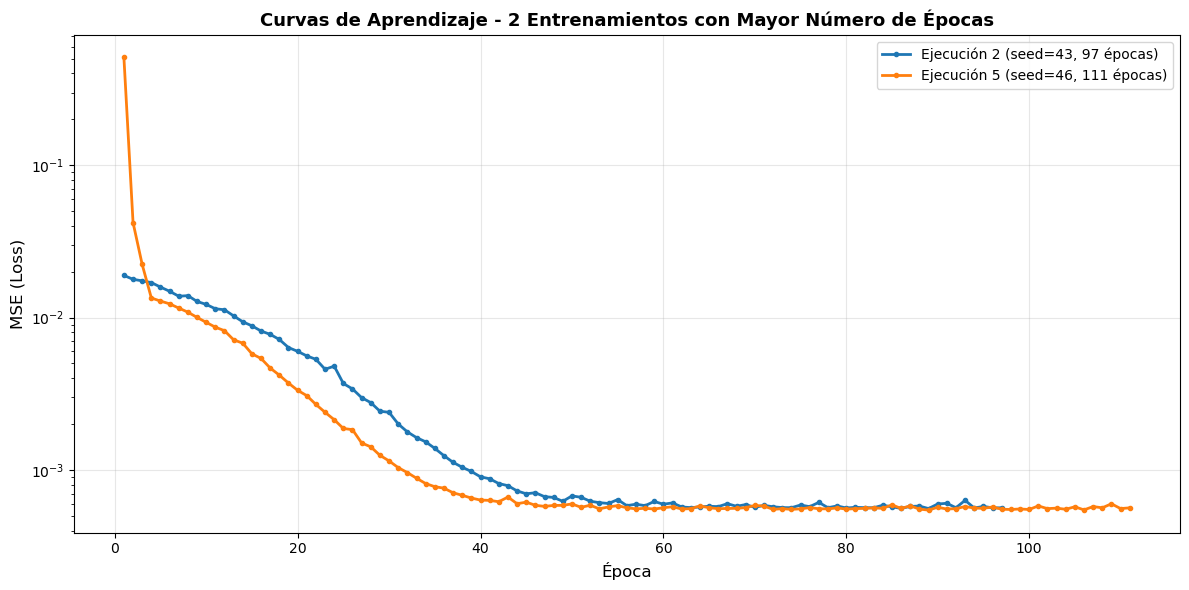


ESTADÍSTICAS RESUMEN

MSE Test:
  Promedio: 0.001692
  Desv. Est: 0.000226
  Mínimo: 0.001436
  Máximo: 0.001962

Número de Épocas:
  Promedio: 83.2
  Mínimo: 50
  Máximo: 111


In [10]:

# Graficar curvas de aprendizaje de los 2 mejores
plt.figure(figsize=(12, 6))

for curva_info in curvas_aprendizaje:
    if curva_info['ejecucion'] in top_2_ejecuciones:
        epocas = range(1, len(curva_info['curva']) + 1)
        label = f"Ejecución {curva_info['ejecucion']} (seed={curva_info['seed']}, {curva_info['n_epocas']} épocas)"
        plt.plot(epocas, curva_info['curva'], linewidth=2, label=label, marker='o', markersize=3)

plt.xlabel('Época', fontsize=12)
plt.ylabel('MSE (Loss)', fontsize=12)
plt.title('Curvas de Aprendizaje - 2 Entrenamientos con Mayor Número de Épocas', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.tight_layout()
plt.show()

# Estadísticas resumen
print("\n" + "="*60)
print("ESTADÍSTICAS RESUMEN")
print("="*60)
print(f"\nMSE Test:")
print(f"  Promedio: {df_resultados['MSE_Test'].mean():.6f}")
print(f"  Desv. Est: {df_resultados['MSE_Test'].std():.6f}")
print(f"  Mínimo: {df_resultados['MSE_Test'].min():.6f}")
print(f"  Máximo: {df_resultados['MSE_Test'].max():.6f}")

print(f"\nNúmero de Épocas:")
print(f"  Promedio: {df_resultados['Num_Epocas'].mean():.1f}")
print(f"  Mínimo: {df_resultados['Num_Epocas'].min()}")
print(f"  Máximo: {df_resultados['Num_Epocas'].max()}")
#punto 3

## SECCIÓN 6: evaluacion 
```
┌──────────────────────────────────────┐
│  6. EVALUACIÓN DEL MODELO            │
└──────────────────────────────────────┘
              ↓
    ┌───────────────────────────┐
    │ evaluar_modelo()          │
    └───────────────────────────┘
              ↓
    ┌─────────────────────────────────┐
    │ ENTRENAMIENTO:                  │
    │ y_train vs y_train_pred         │
    ├─────────────────────────────────┤
    │ MSE  = Σ(real - pred)² / n      │
    │ RMSE = √MSE                     │
    │ MAE  = Σ|real - pred| / n       │
    │ R²   = 1 - (SS_res / SS_tot)    │
    └─────────────────────────────────┘
              ↓
    ┌─────────────────────────────────┐
    │ PRUEBA:                         │
    │ y_test vs y_test_pred           │
    ├─────────────────────────────────┤
    │ (mismas métricas)               │
    └─────────────────────────────────┘
              ↓
    ┌─────────────────────────────────┐
    │ Análisis de Overfitting:        │
    │                                 │
    │ diff_r2 = R²_train - R²_test    │
    │                                 │
    │ if diff_r2 > 0.1:               │
    │   "Overfitting"                 │
    │ elif diff_r2 < 0:               │
    │   "Underfitting"                │
    │ else:                           │
    │   "Generalización OK"           │
    └─────────────────────────────────┘
    ```

In [11]:


def evaluar_modelo(y_true, y_pred, conjunto=""):
    """Calcula métricas de regresión"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{conjunto}:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

print("\n" + "="*60)
print("MÉTRICAS DE EVALUACIÓN")
print("="*60)

metrics_train = evaluar_modelo(y_train, y_train_pred, "ENTRENAMIENTO")
metrics_test = evaluar_modelo(y_test, y_test_pred, "PRUEBA")

# Análisis de overfitting
diff_r2 = metrics_train['r2'] - metrics_test['r2']
print(f"\n{'='*60}")
print(f"Diferencia R² (train - test): {diff_r2:.4f}")
if diff_r2 > 0.1:
    print("  Posible overfitting - considera regularización")
elif diff_r2 < 0:
    print("  Modelo puede estar underfitting")
else:
    print(" Generalización aceptable")


MÉTRICAS DE EVALUACIÓN

ENTRENAMIENTO:
  MSE:  0.001140
  RMSE: 0.033758
  MAE:  0.028149
  R²:   0.964238

PRUEBA:
  MSE:  0.001436
  RMSE: 0.037896
  MAE:  0.030722
  R²:   0.959300

Diferencia R² (train - test): 0.0049
 Generalización aceptable


## SECCIÓN 7: VISUALIZACIONES
```
┌──────────────────────────────────────┐
│  7. VISUALIZACIONES (4 GRÁFICOS)     │
└──────────────────────────────────────┘
              ↓
    ┌───────────────────────────────────┐
    │ Gráfico 1: Scatter Plot           │
    │ ─────────────────────────         │
    │ X: Valores Reales (y_test)        │
    │ Y: Valores Predichos              │
    │ Línea: y = x (perfecto)           │
    └───────────────────────────────────┘
              ↓
    ┌───────────────────────────────────┐
    │ Gráfico 2: Histograma             │
    │ ─────────────────────────         │
    │ Distribución de Errores           │
    │ residuals = y_test - y_test_pred  │
    │ Línea vertical en 0               │
    └───────────────────────────────────┘
              ↓
    ┌───────────────────────────────────┐
    │ Gráfico 3: Curva de Aprendizaje   │
    │ ─────────────────────────         │
    │ X: Número de época                │
    │ Y: Loss (MSE)                     │
    │ Escala: logarítmica               │
    └───────────────────────────────────┘
              ↓
    ┌───────────────────────────────────┐
    │ Gráfico 4: Barras Comparativas    │
    │ ─────────────────────────         │
    │ MSE, MAE, R²                      │
    │ Train vs Test                     │
    └───────────────────────────────────┘
    ```

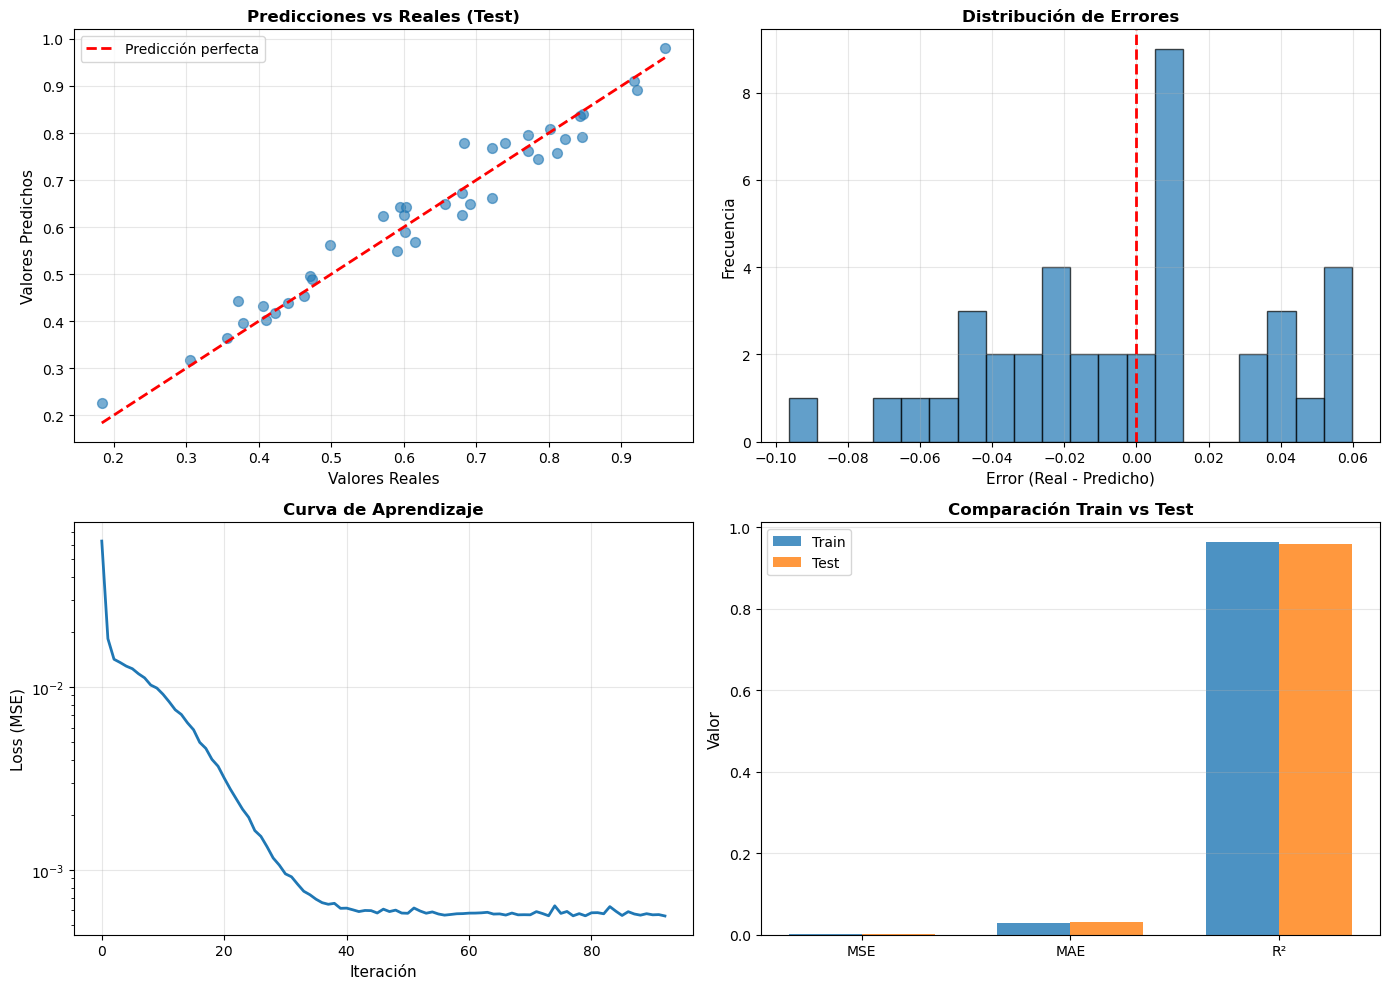

In [12]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Valores reales vs predichos
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, s=50)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Predicción perfecta')
axes[0, 0].set_xlabel('Valores Reales', fontsize=11)
axes[0, 0].set_ylabel('Valores Predichos', fontsize=11)
axes[0, 0].set_title('Predicciones vs Reales (Test)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Distribución de errores
residuals = y_test - y_test_pred
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Error (Real - Predicho)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución de Errores', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Curva de aprendizaje
if hasattr(mlp, 'loss_curve_'):
    axes[1, 0].plot(mlp.loss_curve_, lw=2)
    axes[1, 0].set_xlabel('Iteración', fontsize=11)
    axes[1, 0].set_ylabel('Loss (MSE)', fontsize=11)
    axes[1, 0].set_title('Curva de Aprendizaje', fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    axes[1, 0].set_yscale('log')

# 4. Comparación métricas train vs test
metrics_names = ['MSE', 'MAE', 'R²']
train_values = [metrics_train['mse'], metrics_train['mae'], metrics_train['r2']]
test_values = [metrics_test['mse'], metrics_test['mae'], metrics_test['r2']]

x_pos = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x_pos - width/2, train_values, width, label='Train', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, test_values, width, label='Test', alpha=0.8)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].set_ylabel('Valor', fontsize=11)
axes[1, 1].set_title('Comparación Train vs Test', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## SECCIÓN 8: ANÁLISIS DE LA ARQUITECTURA

In [13]:


print("\n" + "="*60)
print("INFORMACIÓN DE LA ARQUITECTURA")
print("="*60)

print(f"\nNúmero de capas: {mlp.n_layers_}")
print(f"Número de salidas: {mlp.n_outputs_}")
print(f"Función de activación: {mlp.activation}")
print(f"Iteraciones realizadas: {mlp.n_iter_}")

print("\nForma de los pesos por capa:")
for i, (coef, intercept) in enumerate(zip(mlp.coefs_, mlp.intercepts_)):
    print(f"  Capa {i+1}: W{i+1} = {coef.shape}, b{i+1} = {intercept.shape}")

# Total de parámetros
total_params = sum(w.size for w in mlp.coefs_) + sum(b.size for b in mlp.intercepts_)
print(f"\nTotal de parámetros entrenables: {total_params}")
print(f"Ratio muestras/parámetros: {len(X_train)/total_params:.2f}")


INFORMACIÓN DE LA ARQUITECTURA

Número de capas: 3
Número de salidas: 1
Función de activación: logistic
Iteraciones realizadas: 93

Forma de los pesos por capa:
  Capa 1: W1 = (3, 10), b1 = (10,)
  Capa 2: W2 = (10, 1), b2 = (1,)

Total de parámetros entrenables: 51
Ratio muestras/parámetros: 3.14


## SECCIÓN 9: VALIDACIÓN CON DATOS DE VALIDACIÓN 5.3 EXTERNO
```
┌──────────────────────────────────────┐
│  8. VALIDACIÓN CON DATASET EXTERNO   │
└──────────────────────────────────────┘
              ↓
    ┌────────────────────────┐
    │ Cargar validacion.csv  │
    │ (20 muestras)          │
    └────────────────────────┘
              ↓
    ┌────────────────────────────┐
    │ Separar:                   │
    │ X_val = [x1, x2, x3]       │
    │ y_val = [d]                │
    └────────────────────────────┘
              ↓
    ┌────────────────────────────┐
    │ Predicciones:              │
    │ y_val_pred = mlp.predict() │
    │ (solo forward pass)        │
    └────────────────────────────┘
              ↓
    ┌────────────────────────────────┐
    │ Calcular métricas validación   │
    │ MSE, RMSE, MAE, R²             │
    └────────────────────────────────┘
              ↓
    ┌────────────────────────────────────┐
    │ Tabla comparativa:                 │
    │ ┌──────┬────┬────┬──────┐          │
    │ │Conj. │MSE │MAE │  R²  │          │
    │ ├──────┼────┼────┼──────┤          │
    │ │Train │ X  │ Y  │  Z   │          │
    │ │Test  │ X  │ Y  │  Z   │          │
    │ │Valid.│ X  │ Y  │  Z   │          │
    │ └──────┴────┴────┴──────┘          │
    └────────────────────────────────────┘
              ↓
    ┌────────────────────────────────────┐
    │ Análisis de resultados:            │
    │                                    │
    │ • R² > 0.90? → Excelente           │
    │ • R² > 0.75? → Bueno               │
    │ • R² > 0.50? → Aceptable           │
    │ • R² < 0.50? → Pobre               │
    │                                    │
    │ • |R²_train - R²_val| > 0.15?      │
    │   → Overfitting                    │
    └────────────────────────────────────┘
              ↓
    ┌────────────────────────────────────┐
    │ Visualizaciones validación:        │
    │ • Scatter plot                     │
    │ • Histograma errores               │
    │ • Barras comparativas R²           │
    │ • Errores por muestra              │
    └────────────────────────────────────┘
```

#### ¿QUÉ ES LA VALIDACIÓN Y POR QUÉ ES IMPORTANTE?
1. ENTRENAMIENTO (Train):
- Datos que la red "vio" durante el aprendizaje
- El modelo ajustó sus pesos para minimizar el error en estos datos
- Tamaño: 160 muestras (80% del dataset original)

2. PRUEBA (Test):
- Datos que la red NO vio durante el entrenamiento
- Se usaron para evaluar cómo generaliza el modelo
- Tamaño: 40 muestras (20% del dataset original)
- Provienen del MISMO dataset que el entrenamiento

3. VALIDACIÓN (Validation) - ¡ESTE ES EL PASO ACTUAL!:
- Datos COMPLETAMENTE NUEVOS de otra fuente
- Simulan el "mundo real" donde se aplica el modelo
- Son la prueba definitiva de generalización
- Tamaño: 20 muestras (dataset externo)

In [14]:


print("="*70)
print("CARGANDO DATASET DE VALIDACIÓN...")
print("="*70)

# Cargar datos de validación
data_val = pd.read_csv("validacion.csv")
print(f"\nDatos cargados: {data_val.shape[0]} muestras, {data_val.shape[1]} columnas")
print("\nPrimeras 5 muestras del dataset de validación:")
print(data_val.head())

# Separar features y target
X_val = data_val[['x1', 'x2', 'x3']].values
y_val = data_val['d'].values

print(f"\nForma de X_val: {X_val.shape}")
print(f"Forma de y_val: {y_val.shape}")

CARGANDO DATASET DE VALIDACIÓN...

Datos cargados: 20 muestras, 5 columnas

Primeras 5 muestras del dataset de validación:
   Samples      x1      x2      x3       d
0        1  0.0611  0.2860  0.7464  0.4831
1        2  0.5102  0.7464  0.0860  0.5965
2        3  0.0004  0.6916  0.5006  0.5318
3        4  0.9430  0.4476  0.2648  0.6843
4        5  0.1399  0.1610  0.2477  0.2872

Forma de X_val: (20, 3)
Forma de y_val: (20,)


In [15]:
print("Estadísticas del dataset:")
print(data_val.describe())
print(f"\nForma de los datos: {data_val.shape}")

Estadísticas del dataset:
        Samples         x1         x2         x3          d
count  20.00000  20.000000  20.000000  20.000000  20.000000
mean   10.50000   0.432990   0.446075   0.536075   0.602860
std     5.91608   0.338287   0.278634   0.280837   0.150726
min     1.00000   0.000400   0.000700   0.086000   0.287200
25%     5.75000   0.171325   0.245575   0.270125   0.524150
50%    10.50000   0.308900   0.387000   0.571400   0.590050
75%    15.25000   0.716150   0.662125   0.782000   0.710775
max    20.00000   0.999100   0.934200   0.904600   0.809300

Forma de los datos: (20, 5)


#### PREDICCIONES CON LA RED ENTRENADA
¿QUÉ HACE mlp.predict()?
------------------------
El modelo YA ESTÁ ENTRENADO (tiene sus pesos W1, b1, W2, b2 ajustados).
Ahora simplemente hace el "forward pass":

Para cada muestra de validación [x1, x2, x3]:
1. Capa de entrada → Capa oculta:
- z1 = [x1, x2, x3] @ W1 + b1
- a1 = sigmoid(z1)  ← Activación de 10 neuronas ocultas

2. Capa oculta → Capa de salida:
- z2 = a1 @ W2 + b2
- predicción = z2  ← Valor numérico aproximado

NO SE AJUSTAN PESOS. Solo se propaga la información hacia adelante.

In [22]:
# Hacer predicciones
y_val_pred = mlp.predict(X_val)

print(f"\nPredicciones realizadas: {len(y_val_pred)} valores")
print("\nComparación de primeras 5 predicciones:")
print("-" * 60)
print(f"{'Muestra':<10} {'Real (d)':<15} {'Predicho':<15} {'Error':<15}")
print("-" * 60)
for i in range(5):
    error = abs(y_val[i] - y_val_pred[i])
    print(f"{i+1:<10} {y_val[i]:<15.4f} {y_val_pred[i]:<15.4f} {error:<15.4f}")
print("-" * 60)


Predicciones realizadas: 20 valores

Comparación de primeras 5 predicciones:
------------------------------------------------------------
Muestra    Real (d)        Predicho        Error          
------------------------------------------------------------
1          0.4831          0.4948          0.0117         
2          0.5965          0.5812          0.0153         
3          0.5318          0.5301          0.0017         
4          0.6843          0.6889          0.0046         
5          0.2872          0.2992          0.0120         
------------------------------------------------------------


#### MÉTRICAS DE DESEMPEÑO EN VALIDACIÓN

MÉTRICAS EXPLICADAS:
-------------------
1. MSE (Mean Squared Error):
- Promedio de los errores al cuadrado
- Penaliza fuertemente errores grandes
- Valores más cercanos a 0 son mejores
- Fórmula: MSE = (1/n) Σ(real - predicho)²

2. RMSE (Root Mean Squared Error):
- Raíz cuadrada del MSE
- Misma escala que los datos originales
- Interpretación: "error promedio típico"

3. MAE (Mean Absolute Error):
- Promedio de los errores absolutos
- No penaliza tanto errores grandes como MSE
- Fórmula: MAE = (1/n) Σ|real - predicho|

4. R² (Coeficiente de Determinación):
- Mide qué % de variabilidad explica el modelo
- Rango: -∞ a 1.0 (1.0 = perfecto)
- R² = 0.95 → El modelo explica el 95% de la variabilidad

In [23]:
# Calcular métricas
metrics_val = evaluar_modelo(y_val, y_val_pred, "VALIDACIÓN (dataset externo)")

print("\n" + "="*70)
print("COMPARACIÓN: Train vs Test vs Validación")
print("="*70)

# Crear tabla comparativa
comparacion = pd.DataFrame({
    'Conjunto': ['Entrenamiento', 'Prueba (Test)', 'Validación'],
    'Muestras': [len(X_train), len(X_test), len(X_val)],
    'MSE': [metrics_train['mse'], metrics_test['mse'], metrics_val['mse']],
    'RMSE': [metrics_train['rmse'], metrics_test['rmse'], metrics_val['rmse']],
    'MAE': [metrics_train['mae'], metrics_test['mae'], metrics_val['mae']],
    'R²': [metrics_train['r2'], metrics_test['r2'], metrics_val['r2']]
})

print("\n", comparacion.to_string(index=False))

print("\n" + "="*70)
print("INTERPRETACIÓN DE RESULTADOS:")
print("="*70)

# Análisis automático
diff_train_val = abs(metrics_train['r2'] - metrics_val['r2'])
diff_test_val = abs(metrics_test['r2'] - metrics_val['r2'])

if metrics_val['r2'] > 0.90:
    print("✓ EXCELENTE: R² > 0.90 en validación")
    print("  → El modelo generaliza muy bien a datos nuevos")
elif metrics_val['r2'] > 0.75:
    print("✓ BUENO: R² > 0.75 en validación")
    print("  → El modelo tiene buena capacidad de generalización")
elif metrics_val['r2'] > 0.50:
    print("⚠ ACEPTABLE: R² > 0.50 en validación")
    print("  → El modelo tiene capacidad limitada de generalización")
else:
    print("✗ POBRE: R² < 0.50 en validación")
    print("  → El modelo no generaliza bien. Considera:")
    print("    - Más datos de entrenamiento")
    print("    - Revisar arquitectura de la red")
    print("    - Verificar calidad de los datos")

print(f"\nDiferencia Train-Validación: {diff_train_val:.4f}")
if diff_train_val > 0.15:
    print("  ⚠ OVERFITTING DETECTADO")
    print("  → El modelo memorizó el dataset de entrenamiento")
    print("  Soluciones:")
    print("    - Aumentar regularización (alpha)")
    print("    - Reducir complejidad del modelo")
    print("    - Más datos de entrenamiento")
else:
    print("  ✓ Sin evidencia significativa de overfitting")

print(f"\nDiferencia Test-Validación: {diff_test_val:.4f}")
if diff_test_val < 0.05:
    print("  ✓ CONSISTENTE: Desempeño similar en test y validación")
    print("  → La división train/test fue representativa")
else:
    print("  ⚠ Los datos de validación pueden tener características diferentes")


VALIDACIÓN (dataset externo):
  MSE:  0.000177
  RMSE: 0.013292
  MAE:  0.011168
  R²:   0.991813

COMPARACIÓN: Train vs Test vs Validación

      Conjunto  Muestras      MSE     RMSE      MAE       R²
Entrenamiento       160 0.001140 0.033758 0.028149 0.964238
Prueba (Test)        40 0.001436 0.037896 0.030722 0.959300
   Validación        20 0.000177 0.013292 0.011168 0.991813

INTERPRETACIÓN DE RESULTADOS:
✓ EXCELENTE: R² > 0.90 en validación
  → El modelo generaliza muy bien a datos nuevos

Diferencia Train-Validación: 0.0276
  ✓ Sin evidencia significativa de overfitting

Diferencia Test-Validación: 0.0325
  ✓ CONSISTENTE: Desempeño similar en test y validación
  → La división train/test fue representativa



PASO 3: VISUALIZACIÓN DE RESULTADOS


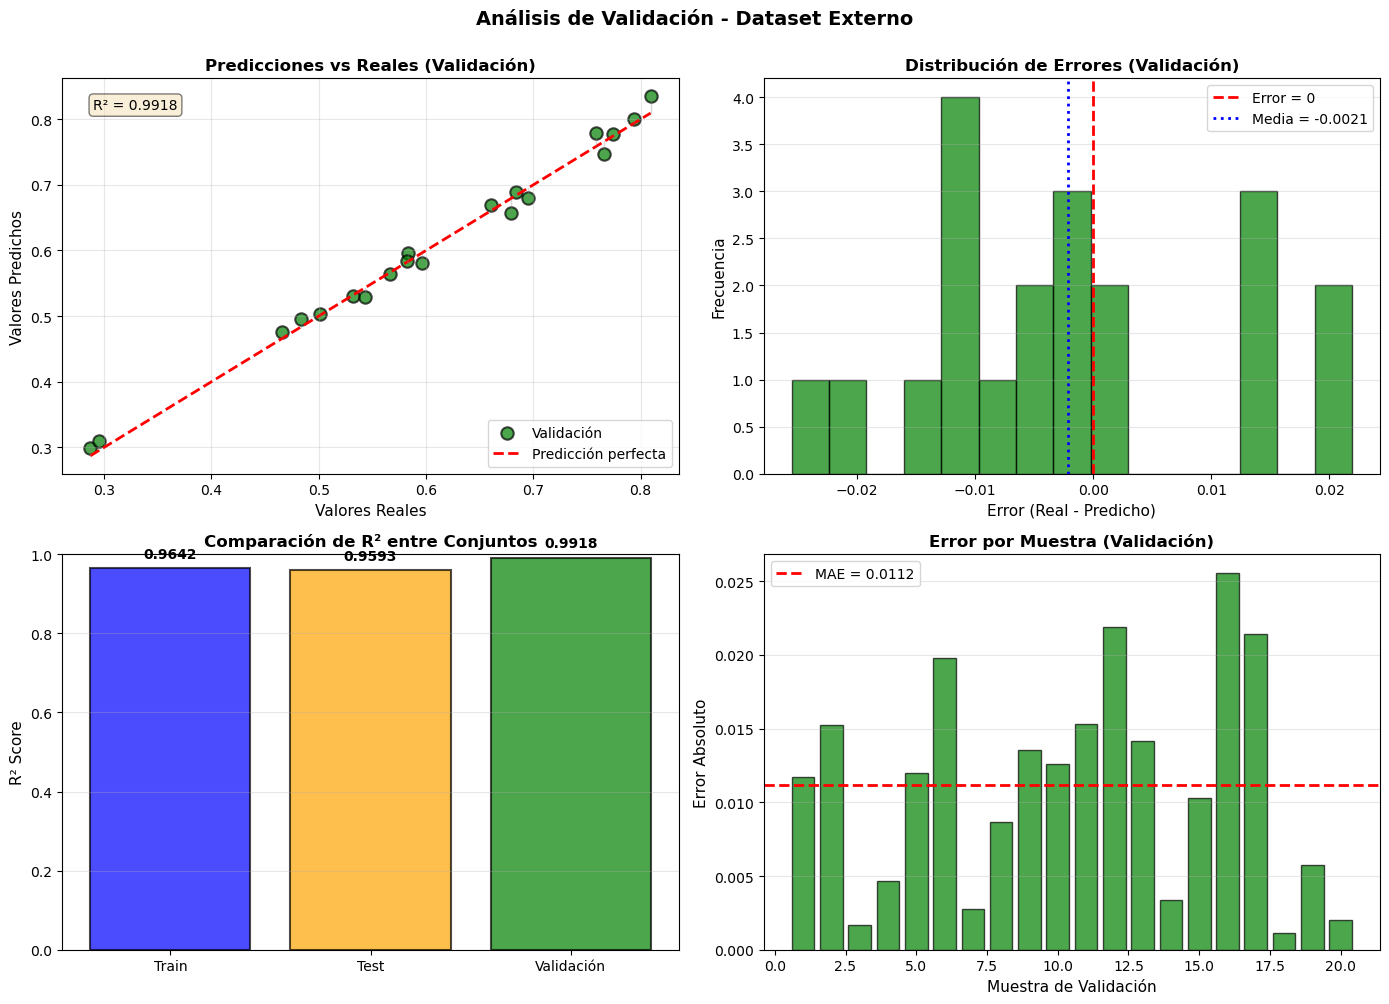


✓ Visualizaciones generadas exitosamente


In [18]:
# =============================================================================
# PASO 3: VISUALIZACIONES DE VALIDACIÓN
# =============================================================================

print("\n" + "="*70)
print("PASO 3: VISUALIZACIÓN DE RESULTADOS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Validación - Dataset Externo',
             fontsize=14, fontweight='bold', y=1.00)

# 1. Predicciones vs Reales (Validación)
axes[0, 0].scatter(y_val, y_val_pred, alpha=0.7, s=80, color='green',
                   edgecolors='black', linewidth=1.5, label='Validación')
axes[0, 0].plot([y_val.min(), y_val.max()],
                [y_val.min(), y_val.max()],
                'r--', lw=2, label='Predicción perfecta')

# Agregar líneas de error
for i in range(len(y_val)):
    axes[0, 0].plot([y_val[i], y_val[i]],
                    [y_val[i], y_val_pred[i]],
                    'gray', alpha=0.3, linewidth=1)

axes[0, 0].set_xlabel('Valores Reales', fontsize=11)
axes[0, 0].set_ylabel('Valores Predichos', fontsize=11)
axes[0, 0].set_title('Predicciones vs Reales (Validación)',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Agregar texto con R²
axes[0, 0].text(0.05, 0.95, f"R² = {metrics_val['r2']:.4f}",
                transform=axes[0, 0].transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Distribución de Errores
residuals_val = y_val - y_val_pred
axes[0, 1].hist(residuals_val, bins=15, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].axvline(0, color='red', linestyle='--', lw=2, label='Error = 0')
axes[0, 1].axvline(residuals_val.mean(), color='blue', linestyle=':', lw=2,
                   label=f'Media = {residuals_val.mean():.4f}')
axes[0, 1].set_xlabel('Error (Real - Predicho)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución de Errores (Validación)',
                     fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Comparación R² entre conjuntos
conjuntos = ['Train', 'Test', 'Validación']
r2_values = [metrics_train['r2'], metrics_test['r2'], metrics_val['r2']]
colors = ['blue', 'orange', 'green']

bars = axes[1, 0].bar(conjuntos, r2_values, color=colors, alpha=0.7,
                      edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('R² Score', fontsize=11)
axes[1, 0].set_title('Comparación de R² entre Conjuntos',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(alpha=0.3, axis='y')

# Agregar valores en las barras
for bar, value in zip(bars, r2_values):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{value:.4f}',
                    ha='center', va='bottom', fontweight='bold')

# 4. Errores por muestra
muestras_idx = range(1, len(y_val) + 1)
errores_abs = np.abs(residuals_val)

axes[1, 1].bar(muestras_idx, errores_abs, color='green', alpha=0.7,
               edgecolor='black', linewidth=1)
axes[1, 1].axhline(errores_abs.mean(), color='red', linestyle='--', lw=2,
                   label=f'MAE = {metrics_val["mae"]:.4f}')
axes[1, 1].set_xlabel('Muestra de Validación', fontsize=11)
axes[1, 1].set_ylabel('Error Absoluto', fontsize=11)
axes[1, 1].set_title('Error por Muestra (Validación)',
                     fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Visualizaciones generadas exitosamente")

#### VALIDACIÓN DEL MODELO
1. PROCESO DE VALIDACIÓN:
- Cargamos datos NUEVOS que el modelo nunca vio
- Usamos mlp.predict() para obtener predicciones (solo forward pass)
- Comparamos predicciones con valores reales
- Calculamos métricas para cuantificar el desempeño

2. INTERPRETACIÓN DE MÉTRICAS:
- MSE/RMSE/MAE → Miden el error promedio
- Valores bajos = buenas predicciones

- R² → Mide qué tan bien explica el modelo los datos
- Cerca de 1.0 = excelente
- 0.7-0.9 = bueno
- < 0.5 = pobre

3. IMPORTANCIA DE LA VALIDACIÓN EXTERNA:
- Test set: Evalúa generalización dentro del mismo dataset
- Validation set: Evalúa generalización a datos completamente nuevos

Si el modelo funciona bien en validación externa:
- Aprendió patrones generales (no solo memorizó)
- Puede usarse con confianza en producción
- Es robusto a variaciones en los datos

4. PRÓXIMOS PASOS SUGERIDOS:
- Si R² validación < R² test: Investigar diferencias en los datos
- Si hay overfitting: Aumentar regularización o simplificar modelo
- Si el modelo es bueno: ¡Úsalo para hacer predicciones reales!

In [25]:


print("\n" + "="*70)
print("RESUMEN EJECUTIVO - VALIDACIÓN DEL MODELO")
print("="*70)

print(f"""
ARQUITECTURA DEL MODELO:
  • Capas: 3 (entrada → oculta → salida)
  • Neuronas ocultas: {HYPERPARAMS['hidden_layers'][0]}
  • Función de activación: {HYPERPARAMS['activation']} (sigmoide)
  • Parámetros totales: {total_params}
  • Épocas de entrenamiento: {mlp.n_iter_}

DATOS UTILIZADOS:
  • Entrenamiento: {len(X_train)} muestras (usadas para aprender)
  • Prueba (Test): {len(X_test)} muestras (evaluación interna)
  • Validación: {len(X_val)} muestras (dataset externo - ESTE ANÁLISIS)

RESULTADOS DE VALIDACIÓN:
  • MSE:  {metrics_val['mse']:.6f}
  • RMSE: {metrics_val['rmse']:.6f}
  • MAE:  {metrics_val['mae']:.6f}
  • R²:   {metrics_val['r2']:.6f}
""")


print("="*70)
print("FIN DEL ANÁLISIS DE VALIDACIÓN")
print("="*70)


RESUMEN EJECUTIVO - VALIDACIÓN DEL MODELO

ARQUITECTURA DEL MODELO:
  • Capas: 3 (entrada → oculta → salida)
  • Neuronas ocultas: 10
  • Función de activación: logistic (sigmoide)
  • Parámetros totales: 51
  • Épocas de entrenamiento: 93

DATOS UTILIZADOS:
  • Entrenamiento: 160 muestras (usadas para aprender)
  • Prueba (Test): 40 muestras (evaluación interna)
  • Validación: 20 muestras (dataset externo - ESTE ANÁLISIS)

RESULTADOS DE VALIDACIÓN:
  • MSE:  0.000177
  • RMSE: 0.013292
  • MAE:  0.011168
  • R²:   0.991813

FIN DEL ANÁLISIS DE VALIDACIÓN


In [20]:
# =============================================================================
# PREDICCIÓN CON 5 ENTRENAMIENTOS DIFERENTES
# =============================================================================

print("\n" + "="*70)
print("PREDICCIONES CON 5 ENTRENAMIENTOS DIFERENTES")
print("="*70)

# Cargar datos de validación
data_val = pd.read_csv("validacion.csv")
X_val = data_val[['x1', 'x2', 'x3']].values
y_val = data_val['d'].values

# Crear DataFrame para almacenar resultados
resultados_predicciones = pd.DataFrame({
    'Sample': data_val['Samples'],
    'x1': data_val['x1'],
    'x2': data_val['x2'],
    'x3': data_val['x3'],
    'd_real': y_val
})

# Lista para almacenar métricas de cada modelo
metricas_modelos = []

# Entrenar 5 modelos y hacer predicciones
print("\nEntrenando 5 modelos y generando predicciones...\n")

for i in range(5):
    seed = 42 + i
    print(f"Modelo {i+1}/5 (seed={seed})... ", end='')
    
    # Crear y entrenar modelo
    mlp_temp = MLPRegressor(
        hidden_layer_sizes=HYPERPARAMS['hidden_layers'],
        activation=HYPERPARAMS['activation'],
        solver=HYPERPARAMS['solver'],
        alpha=HYPERPARAMS['alpha'],
        batch_size=HYPERPARAMS['batch_size'],
        learning_rate_init=HYPERPARAMS['learning_rate'],
        max_iter=HYPERPARAMS['max_iter'],
        tol=HYPERPARAMS['tol'],
        n_iter_no_change=HYPERPARAMS['n_iter_no_change'],
        early_stopping=HYPERPARAMS['early_stopping'],
        validation_fraction=HYPERPARAMS['validation_fraction'],
        random_state=seed,
        verbose=False
    )
    
    mlp_temp.fit(X_train, y_train)
    
    # Hacer predicciones en validación
    y_val_pred = mlp_temp.predict(X_val)
    
    # Agregar predicciones al DataFrame
    col_name = f'd_pred_{i+1}'
    resultados_predicciones[col_name] = y_val_pred
    
    # Calcular métricas
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    metricas_modelos.append({
        'Modelo': i + 1,
        'Seed': seed,
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'Epocas': mlp_temp.n_iter_
    })
    
    print(f"✓ MSE: {mse:.6f}, R²: {r2:.4f}, Épocas: {mlp_temp.n_iter_}")

# Calcular promedio y desviación estándar de las predicciones
predicciones_cols = [f'd_pred_{i+1}' for i in range(5)]
resultados_predicciones['d_pred_promedio'] = resultados_predicciones[predicciones_cols].mean(axis=1)
resultados_predicciones['d_pred_std'] = resultados_predicciones[predicciones_cols].std(axis=1)
resultados_predicciones['error_promedio'] = abs(resultados_predicciones['d_real'] - resultados_predicciones['d_pred_promedio'])

print("\n" + "="*70)
print("DATAFRAME DE RESULTADOS")
print("="*70)
print("\n", resultados_predicciones.to_string(index=False))

# Mostrar métricas de cada modelo
print("\n" + "="*70)
print("MÉTRICAS DE CADA MODELO")
print("="*70)
df_metricas = pd.DataFrame(metricas_modelos)
print("\n", df_metricas.to_string(index=False))

# Estadísticas del promedio
mse_promedio = mean_squared_error(y_val, resultados_predicciones['d_pred_promedio'])
mae_promedio = mean_absolute_error(y_val, resultados_predicciones['d_pred_promedio'])
r2_promedio = r2_score(y_val, resultados_predicciones['d_pred_promedio'])

print("\n" + "="*70)
print("MÉTRICAS DEL PROMEDIO DE LOS 5 MODELOS")
print("="*70)
print(f"MSE:  {mse_promedio:.6f}")
print(f"MAE:  {mae_promedio:.6f}")
print(f"R²:   {r2_promedio:.4f}")

print("\n" + "="*70)
print("ESTADÍSTICAS DE VARIABILIDAD")
print("="*70)
print(f"Desviación estándar promedio entre modelos: {resultados_predicciones['d_pred_std'].mean():.6f}")
print(f"Desviación estándar máxima: {resultados_predicciones['d_pred_std'].max():.6f}")
print(f"Desviación estándar mínima: {resultados_predicciones['d_pred_std'].min():.6f}")
#punto 5


PREDICCIONES CON 5 ENTRENAMIENTOS DIFERENTES

Entrenando 5 modelos y generando predicciones...

Modelo 1/5 (seed=42)... ✓ MSE: 0.000177, R²: 0.9918, Épocas: 93
Modelo 2/5 (seed=43)... ✓ MSE: 0.000212, R²: 0.9902, Épocas: 97
Modelo 3/5 (seed=44)... ✓ MSE: 0.000507, R²: 0.9765, Épocas: 65
Modelo 4/5 (seed=45)... ✓ MSE: 0.000388, R²: 0.9820, Épocas: 50
Modelo 5/5 (seed=46)... ✓ MSE: 0.000207, R²: 0.9904, Épocas: 111

DATAFRAME DE RESULTADOS

  Sample     x1     x2     x3  d_real  d_pred_1  d_pred_2  d_pred_3  d_pred_4  d_pred_5  d_pred_promedio  d_pred_std  error_promedio
      1 0.0611 0.2860 0.7464  0.4831  0.494818  0.497129  0.516448  0.510867  0.493859         0.502624    0.010332        0.019524
      2 0.5102 0.7464 0.0860  0.5965  0.581235  0.587546  0.592599  0.581402  0.569789         0.582514    0.008541        0.013986
      3 0.0004 0.6916 0.5006  0.5318  0.530125  0.529048  0.545116  0.535030  0.524225         0.532709    0.007927        0.000909
      4 0.9430 0.4476 0.264

/tmp/ipykernel_14118/758677646.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(data_boxplot, labels=labels_boxplot, patch_artist=True)


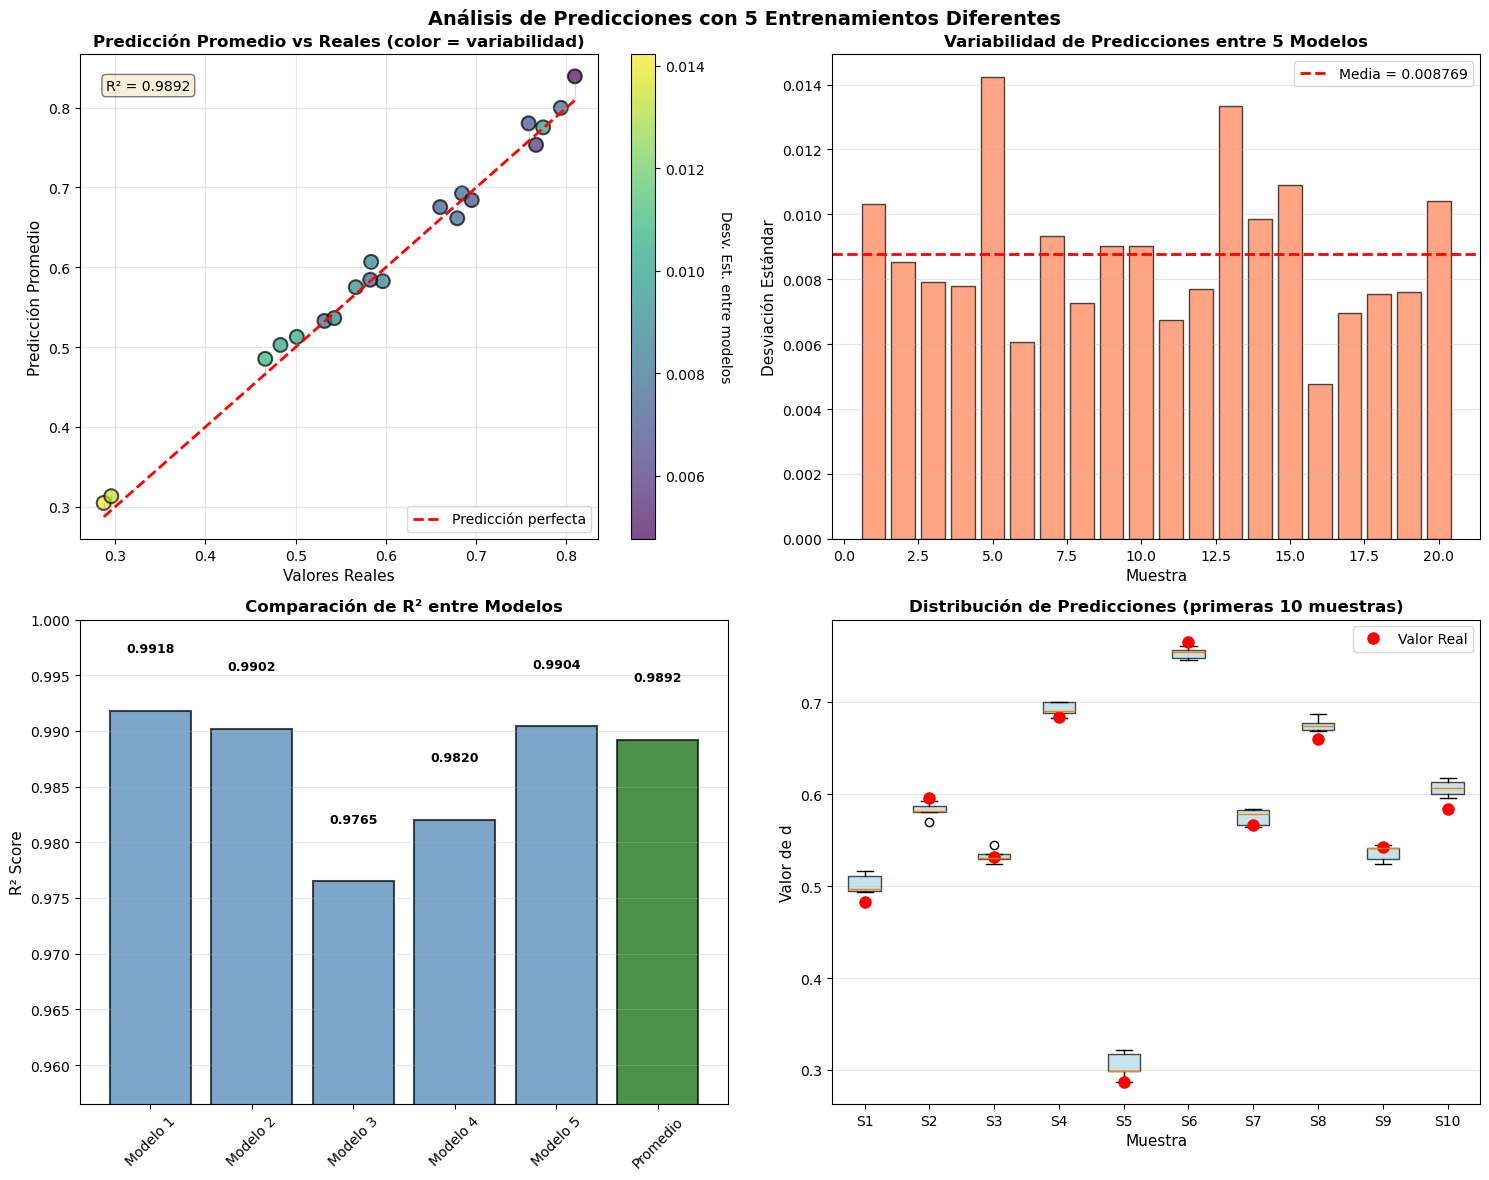


✓ Visualizaciones generadas exitosamente


In [21]:
# =============================================================================
# VISUALIZACIÓN DE PREDICCIONES CON 5 MODELOS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis de Predicciones con 5 Entrenamientos Diferentes',
             fontsize=14, fontweight='bold')

# 1. Predicciones promedio vs Reales
axes[0, 0].scatter(resultados_predicciones['d_real'], 
                   resultados_predicciones['d_pred_promedio'],
                   alpha=0.7, s=100, c=resultados_predicciones['d_pred_std'],
                   cmap='viridis', edgecolor='black', linewidth=1.5)
axes[0, 0].plot([y_val.min(), y_val.max()],
                [y_val.min(), y_val.max()],
                'r--', lw=2, label='Predicción perfecta')

# Agregar líneas de error
for i in range(len(resultados_predicciones)):
    axes[0, 0].plot([resultados_predicciones['d_real'].iloc[i], 
                     resultados_predicciones['d_real'].iloc[i]],
                    [resultados_predicciones['d_real'].iloc[i], 
                     resultados_predicciones['d_pred_promedio'].iloc[i]],
                    'gray', alpha=0.3, linewidth=1)

cbar = plt.colorbar(axes[0, 0].collections[0], ax=axes[0, 0])
cbar.set_label('Desv. Est. entre modelos', rotation=270, labelpad=20)

axes[0, 0].set_xlabel('Valores Reales', fontsize=11)
axes[0, 0].set_ylabel('Predicción Promedio', fontsize=11)
axes[0, 0].set_title('Predicción Promedio vs Reales (color = variabilidad)',
                     fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
axes[0, 0].text(0.05, 0.95, f"R² = {r2_promedio:.4f}",
                transform=axes[0, 0].transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Variabilidad entre modelos por muestra
axes[0, 1].bar(resultados_predicciones['Sample'], 
               resultados_predicciones['d_pred_std'],
               color='coral', alpha=0.7, edgecolor='black', linewidth=1)
axes[0, 1].axhline(resultados_predicciones['d_pred_std'].mean(),
                   color='red', linestyle='--', lw=2,
                   label=f'Media = {resultados_predicciones["d_pred_std"].mean():.6f}')
axes[0, 1].set_xlabel('Muestra', fontsize=11)
axes[0, 1].set_ylabel('Desviación Estándar', fontsize=11)
axes[0, 1].set_title('Variabilidad de Predicciones entre 5 Modelos',
                     fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Comparación de R² entre los 5 modelos
modelos = [f'Modelo {i+1}' for i in range(5)] + ['Promedio']
r2_valores = [m['R2'] for m in metricas_modelos] + [r2_promedio]
colores = ['steelblue'] * 5 + ['darkgreen']

bars = axes[1, 0].bar(modelos, r2_valores, color=colores, alpha=0.7,
                      edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('R² Score', fontsize=11)
axes[1, 0].set_title('Comparación de R² entre Modelos',
                     fontsize=12, fontweight='bold')
axes[1, 0].set_ylim([min(r2_valores) - 0.02, 1.0])
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=45)

# Agregar valores en las barras
for bar, value in zip(bars, r2_valores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                    f'{value:.4f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Boxplot de predicciones por muestra (primeras 10 muestras)
muestras_seleccionadas = resultados_predicciones.head(10)
data_boxplot = []
labels_boxplot = []

for idx, row in muestras_seleccionadas.iterrows():
    predicciones = [row[f'd_pred_{i+1}'] for i in range(5)]
    data_boxplot.append(predicciones)
    labels_boxplot.append(f"S{int(row['Sample'])}")

bp = axes[1, 1].boxplot(data_boxplot, labels=labels_boxplot, patch_artist=True)

# Colorear boxplots
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

# Agregar los valores reales como puntos rojos
for i, (idx, row) in enumerate(muestras_seleccionadas.iterrows()):
    axes[1, 1].plot(i + 1, row['d_real'], 'ro', markersize=8, 
                    label='Valor Real' if i == 0 else '')

axes[1, 1].set_xlabel('Muestra', fontsize=11)
axes[1, 1].set_ylabel('Valor de d', fontsize=11)
axes[1, 1].set_title('Distribución de Predicciones (primeras 10 muestras)',
                     fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Visualizaciones generadas exitosamente")